# MNIST Digit Classification from Scratch (NumPy Only)

This project builds a simple neural network from scratch using NumPy to classify handwritten digits from the MNIST dataset. The model uses forward and backward propagation with ReLU and Softmax, and is trained using cross-entropy loss and gradient descent.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading and Preprocessing the MNIST Dataset

The MNIST dataset contains 28x28 grayscale images of handwritten digits (0–9). Each image is flattened into a 784-length vector. The labels are one-hot encoded to work with our custom neural network.


In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


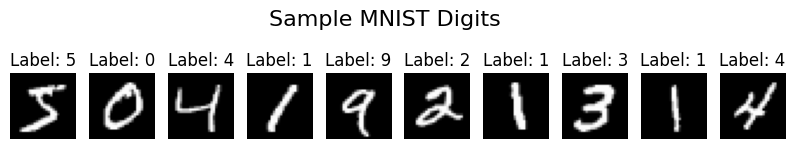

In [3]:
plt.figure(figsize=(10,2))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.imshow(x_train[i].reshape(28,28),cmap = 'gray')
  plt.title(f"Label: {y_train[i]}")
  plt.axis('off')
plt.suptitle('Sample MNIST Digits',fontsize = 16)
plt.show()

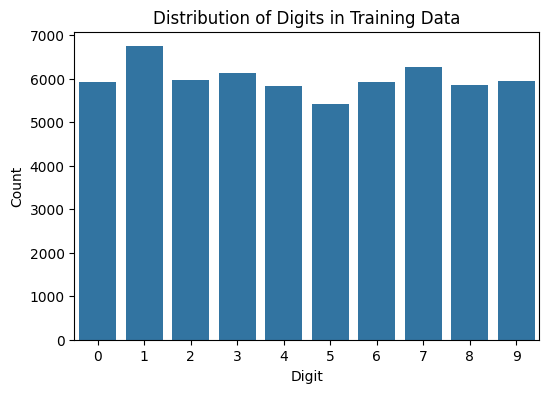

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title("Distribution of Digits in Training Data")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

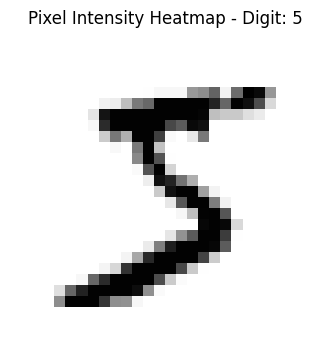

In [5]:
# Show intensity heatmap of a digit (e.g. digit at index 0)
plt.figure(figsize=(4, 4))
sns.heatmap(x_train[0].reshape(28, 28), cmap="Greys", cbar=False)
plt.title(f"Pixel Intensity Heatmap - Digit: {y_train[0]}")
plt.axis('off')
plt.show()

In [6]:
# Shapes
print("Training set shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test set shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

# Unique classes
print("Unique classes:", np.unique(y_train))

# Data types
print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Check for NaN values
print("NaNs in x_train:", np.isnan(x_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())

Training set shape: (60000, 28, 28)
Training labels shape: (60000,)
Test set shape: (10000, 28, 28)
Test labels shape: (10000,)
Unique classes: [0 1 2 3 4 5 6 7 8 9]
x_train dtype: uint8
y_train dtype: uint8
NaNs in x_train: 0
NaNs in y_train: 0


In [7]:
print(np.isnan(x_train).sum(), np.isnan(y_train).sum())
print(np.isnan(x_test).sum(), np.isnan(y_test).sum())

0 0
0 0


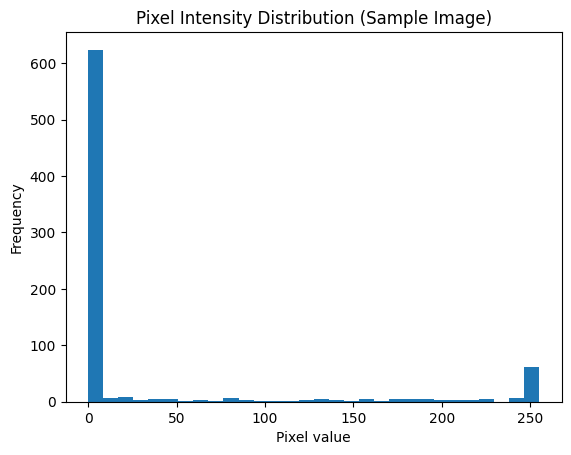

In [8]:
plt.hist(x_train[0].ravel(), bins=30)
plt.title("Pixel Intensity Distribution (Sample Image)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()


In [9]:
print("Mean pixel value:", x_train.mean())
print("Standard deviation:", x_train.std())

Mean pixel value: 33.318421449829934
Standard deviation: 78.56748998339798


In [10]:
# Flatten the 28x28 images to 784-length vectors
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Normalize pixel values to [0, 1]
x_train_flat = x_train_flat / 255.0
x_test_flat = x_test_flat / 255.0

print("Flattened and normalized x_train shape:", x_train_flat.shape)
print("Flattened and normalized x_test shape:", x_test_flat.shape)


Flattened and normalized x_train shape: (60000, 784)
Flattened and normalized x_test shape: (10000, 784)


In [11]:
def one_hot_encode(y, num_classes=10):
    return np.eye(num_classes)[y]

y_train_encoded = one_hot_encode(y_train)
y_test_encoded = one_hot_encode(y_test)

print("Encoded label shape:", y_train_encoded.shape)
print("Example:\n", y_train[0], "→", y_train_encoded[0])

Encoded label shape: (60000, 10)
Example:
 5 → [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 2. Neural Network Architecture

This is a 2-layer fully connected neural network:
- Input layer: 784 units
- Hidden layer: 64 units (with ReLU)
- Output layer: 10 units (with Softmax)

Weights are initialized randomly. Bias terms are also added for each layer.


In [25]:
np.random.seed(42)

input_size = 784
hidden_size = 64
output_size = 10

w1 = np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
w2 = np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

## 3. Forward and Backward Propagation

The forward pass computes predictions. ReLU is used for non-linearity, and Softmax for classification. The backward pass computes gradients using cross-entropy loss and updates weights via gradient descent.


In [26]:
def relu(x):
  return np.maximum(0, x)

def softmax(x):
  exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # for numerical stability
  return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def forward_pass(x,w1,b1,w2,b2):
  z1 = np.dot(x,w1) + b1
  a1 = relu(z1)
  z2 = np.dot(a1,w2) + b2
  output = softmax(z2)
  return z1,a1,z2,output

In [27]:
def cross_entropy_loss(predictions, labels):
  return -np.mean(np.sum(labels * np.log(predictions + 1e-9), axis=1))

In [28]:
def backward_pass(x,y_true, z1,a1,z2, y_pred,w2):

  dz2 = y_pred - y_true
  dw2 = np.dot(a1.T, dz2)
  db2 = np.sum(dz2, axis=0)

  da1 = np.dot(dz2, w2.T)
  dz1 = da1 * (z1 > 0)
  dw1 = np.dot(x.T, dz1)
  db1 = np.sum(dz1, axis=0)

  return dw1,db1,dw2,db2

## 4. Training the Network

Training is done in mini-batches using stochastic gradient descent. For each batch, the model:
1. Computes predictions
2. Calculates loss
3. Performs backpropagation
4. Updates weights

Loss is tracked across epochs.


In [29]:
def train(x_train, y_train, W1, b1, W2, b2, epochs=10, lr=0.01, batch_size=32):
    for epoch in range(epochs):
        permutation = np.random.permutation(len(x_train))
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]

        loss = 0
        for i in range(0, len(x_train), batch_size):
            x_batch = x_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            z1, a1, z2, y_pred = forward_pass(x_batch, W1, b1, W2, b2)
            loss += cross_entropy_loss(y_pred, y_batch)

            dW1, dB1, dW2, dB2 = backward_pass(x_batch, y_batch, z1, a1, z2, y_pred, W2)

            # Update weights and biases
            W1 -= lr * dW1
            b1 -= lr * dB1
            W2 -= lr * dW2
            b2 -= lr * dB2

        avg_loss = loss / (len(x_train) / batch_size)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")


In [34]:
# Train the model
train(x_train_flat, y_train_encoded, w1,b1, w2,b2, epochs=20, lr=0.01, batch_size=64)

Epoch 1/20, Loss: 0.1847
Epoch 2/20, Loss: 0.1753
Epoch 3/20, Loss: 0.1687
Epoch 4/20, Loss: 0.1636
Epoch 5/20, Loss: 0.1573
Epoch 6/20, Loss: 0.1526
Epoch 7/20, Loss: 0.1472
Epoch 8/20, Loss: 0.1425
Epoch 9/20, Loss: 0.1392
Epoch 10/20, Loss: 0.1354
Epoch 11/20, Loss: 0.1302
Epoch 12/20, Loss: 0.1274
Epoch 13/20, Loss: 0.1235
Epoch 14/20, Loss: 0.1191
Epoch 15/20, Loss: 0.1176
Epoch 16/20, Loss: 0.1144
Epoch 17/20, Loss: 0.1112
Epoch 18/20, Loss: 0.1090
Epoch 19/20, Loss: 0.1061
Epoch 20/20, Loss: 0.1024


## 5. Model Evaluation

We evaluate performance using test accuracy. A confusion matrix gives deeper insights into misclassifications.


In [35]:
_, _, _, test_preds = forward_pass(x_test_flat, w1, b1, w2, b2)

predicted_labels = np.argmax(test_preds, axis=1)

accuracy = np.mean(predicted_labels == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 94.77%


## 6. Confusion Matrix Visualization

The confusion matrix shows how well the model distinguishes each digit. Ideally, most predictions fall on the diagonal.


In [38]:
from sklearn.metrics import confusion_matrix
# Get predictions
_, _, _, y_pred_probs = forward_pass(x_test_flat, w1, b1, w2, b2)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
cm

array([[ 958,    0,    2,    3,    0,    6,    6,    2,    2,    1],
       [   0, 1117,    4,    1,    0,    0,    4,    1,    5,    3],
       [   4,    1,  986,    5,    4,    1,    4,    6,   21,    0],
       [   0,    1,   12,  945,    0,   16,    0,    6,   23,    7],
       [   1,    4,    5,    0,  901,    2,    7,    9,    3,   50],
       [   3,    1,    1,   11,    0,  849,    8,    2,   11,    6],
       [   9,    3,    4,    0,   11,   15,  906,    0,   10,    0],
       [   3,    5,   19,   12,    3,    1,    0,  942,    4,   39],
       [   9,    4,    9,   10,    5,    7,    4,    4,  912,   10],
       [   3,    2,    1,    8,    7,    7,    1,    3,   16,  961]])

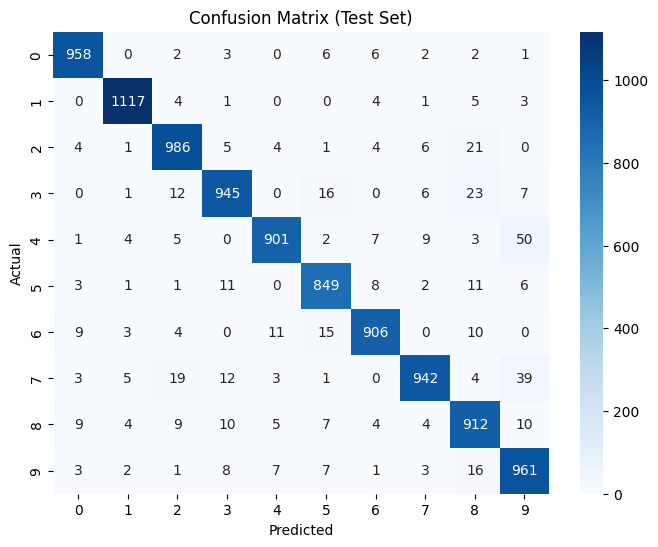

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.show()


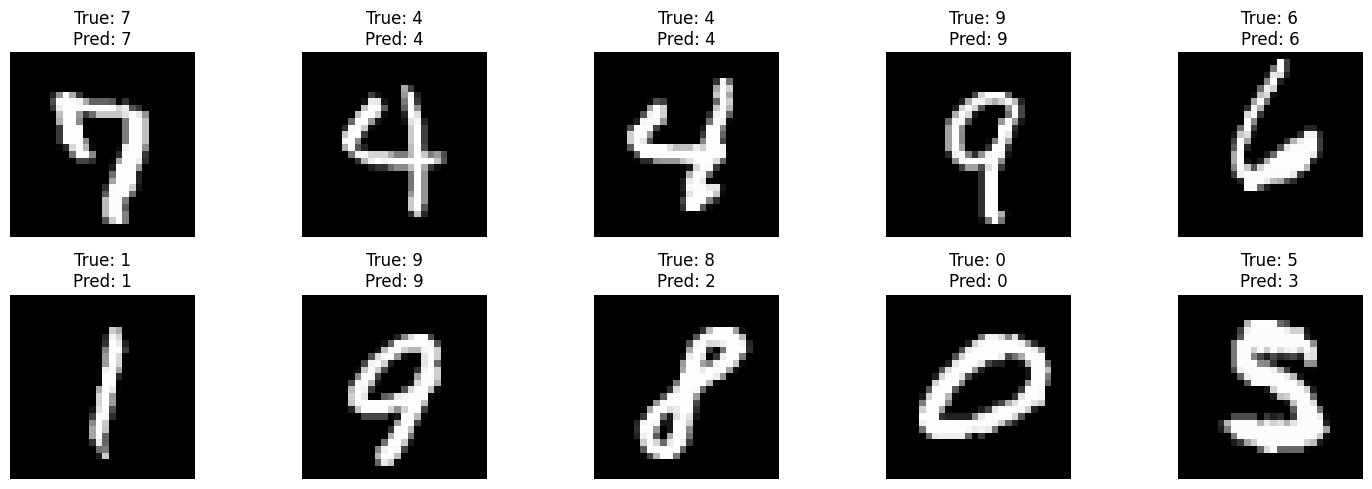

In [42]:
import matplotlib.pyplot as plt

# Pick some random images from the test set
num_images = 10
indices = np.random.choice(len(x_test), num_images)

# Flatten test images if needed
x_sample = x_test[indices].reshape(num_images, -1)
y_true_sample = y_test[indices]

# Get predictions
_, _, _, y_pred_probs = forward_pass(x_sample, w1, b1, w2, b2)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Plot the images with true and predicted labels
plt.figure(figsize=(15, 5))
for i in range(num_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_sample[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {y_true_sample[i]}\nPred: {y_pred_labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 7. Conclusion

This project demonstrates how to build and train a simple neural network from scratch using NumPy. The model achieves over 94% test accuracy on the MNIST dataset. This is a great foundation for understanding how deep learning frameworks work internally.
